In [20]:
from utils.db import load_all_rows_from_mongo
from utils.functions import processar_indicadores_financeiros, prophet_ar2_forecast, forecast_future_periods
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
#from sklearn.metrics import mean_absolute_error, mean_squared_error

In [32]:
all_rows = load_all_rows_from_mongo(coll_name="industrial_nordeste")

df_hist = pd.DataFrame(all_rows)
indicadores_historicos = processar_indicadores_financeiros(df_hist)

In [3]:
indicadores_historicos['Margem_de_Lucro'] = np.log1p(
    indicadores_historicos['Margem_de_Lucro'])

In [7]:
resultado = adfuller(indicadores_historicos['Liquidez_Imediata'])
p_valor = resultado[1]

print(f"p-valor: {p_valor:.4f}")

if p_valor < 0.05:
    print("✅ A série é estacionária (rejeita H₀).")
else:
    print("⚠️ A série NÃO é estacionária (não rejeita H₀). O Prophet consegue lidar com isso.")

p-valor: 0.0000
✅ A série é estacionária (rejeita H₀).


In [ ]:
# Garante que o índice seja um datetime (necessário para extrair o mês)
indicadores_historicos.index = pd.to_datetime(indicadores_historicos.index)

# Cria uma coluna de mês (sem conflito com o índice)
indicadores_historicos = indicadores_historicos.copy()
indicadores_historicos['mes_num'] = indicadores_historicos.index.month

# Agrupa os valores de Liquidez_Imediata por mês
grupos = [grupo['Liquidez_Imediata'].values for _,
          grupo in indicadores_historicos.groupby('mes_num')]

# Teste de Kruskal–Wallis para comparar médias entre meses
stat, p = kruskal(*grupos)
print(f"Estatística H = {stat:.3f}, p-valor = {p:.4f}")

if p < 0.05:
    print("✅ Há evidências de sazonalidade (diferenças significativas entre meses).")
else:
    print("⚠️ Não há evidências fortes de sazonalidade.")

Estatística H = 5.901, p-valor = 0.8799
⚠️ Não há evidências fortes de sazonalidade.


In [11]:
lb = acorr_ljungbox(indicadores_historicos['Liquidez_Imediata'], lags=[
                    4], return_df=True)
p_valor = lb['lb_pvalue'].iloc[-1]  # pega o p-valor do último lag

print(lb)
print(f"\nP-valor (lag 12): {p_valor:.4f}")

if p_valor < 0.05:
    print("✅ A série apresenta autocorrelação significativa (rejeita H₀).")
else:
    print("⚠️ A série NÃO apresenta autocorrelação significativa (não rejeita H₀).")

    lb_stat  lb_pvalue
4  3.992409   0.407034

P-valor (lag 12): 0.4070
⚠️ A série NÃO apresenta autocorrelação significativa (não rejeita H₀).


In [33]:
indicadores_historicos.index = pd.to_datetime(
    indicadores_historicos.index, format="%Y-%m")

In [34]:

resultado = prophet_ar2_forecast(
    indicadores_historicos, target_col='Margem_de_Lucro', horizon=6)

# acessar métricas
print(resultado['MAE'], resultado['RMSE'], resultado['MAPE'])

# visualizar previsões
print(resultado['forecast_df'])

23:12:01 - cmdstanpy - INFO - Chain [1] start processing
23:12:02 - cmdstanpy - INFO - Chain [1] done processing


📈 AR(2) via Prophet - coluna: Margem_de_Lucro
MAE :  0.1805
RMSE:  0.2407
MAPE:  27.38%
0.18052786494046122 0.24072453276830563 27.38098685045991
          ds    y_true    y_pred
0 2024-07-01  0.666550  0.942914
1 2024-08-01  0.618309  0.203902
2 2024-09-01  0.642877  0.633296
3 2024-10-01  0.680072  0.628870
4 2024-11-01  0.663741  0.684836
5 2024-12-01  0.712133  1.022650


<Figure size 1000x400 with 0 Axes>

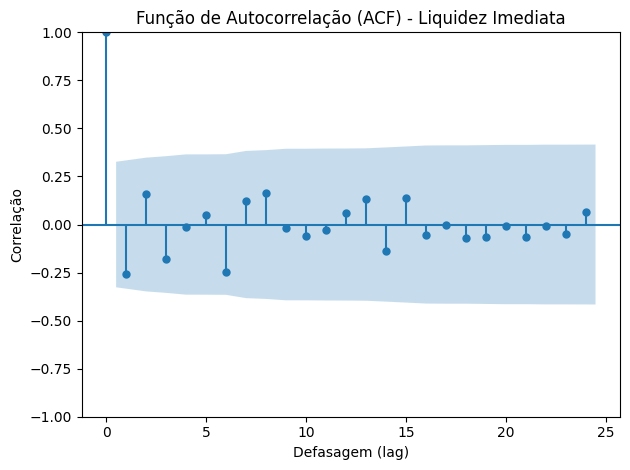

In [26]:
#Plotar a função de autocorrelação
serie = indicadores_historicos['Liquidez_Imediata'].dropna()
plt.figure(figsize=(10, 4))
plot_acf(serie, lags=24, alpha=0.05)  # até 24 defasagens (meses)
plt.title("Função de Autocorrelação (ACF) - Liquidez Imediata")
plt.xlabel("Defasagem (lag)")
plt.ylabel("Correlação")
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

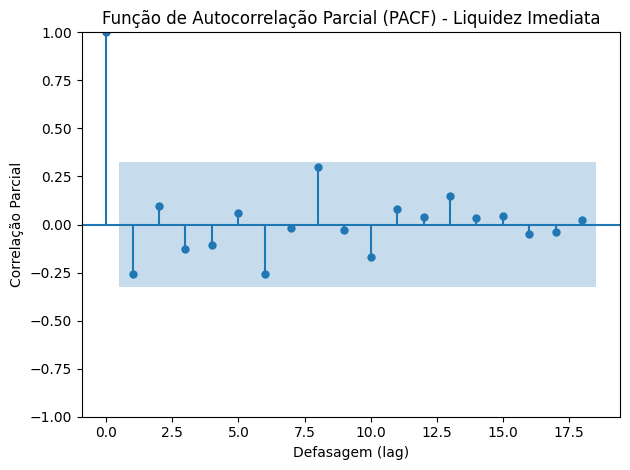

In [27]:
plt.figure(figsize=(10, 4))
plot_pacf(serie, lags=18, alpha=0.05, method='ywm')
plt.title("Função de Autocorrelação Parcial (PACF) - Liquidez Imediata")
plt.xlabel("Defasagem (lag)")
plt.ylabel("Correlação Parcial")
plt.tight_layout()
plt.show()

In [25]:
indicadores_historicos.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2022-01-01 to 2024-12-01
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ativo_Circulante                  36 non-null     float64
 1   Ativo_Nao_Circulante              36 non-null     float64
 2   Passivo_Circulante                36 non-null     float64
 3   Passivo_Nao_Circulante            36 non-null     float64
 4   Patrimonio_Liquido                36 non-null     float64
 5   Receita_Bruta                     36 non-null     float64
 6   Impostos_Receita                  36 non-null     float64
 7   Custo_Total                       36 non-null     float64
 8   Disponibilidade_Caixa             36 non-null     float64
 9   Receita_Líquida                   36 non-null     float64
 10  Lucro_Bruto                       36 non-null     float64
 11  Lucro_Líquido                     36 non-null     flo

In [29]:
previsao_futura = forecast_future_periods(
    indicadores_historicos, target_col='Liquidez_Imediata', horizon=6)

previsao_futura

21:59:46 - cmdstanpy - INFO - Chain [1] start processing
21:59:46 - cmdstanpy - INFO - Chain [1] done processing


✅ Previsão futura concluída com sucesso!


,ds,forecast
0,2025-01-01,0.420741
1,2025-02-01,0.625147
2,2025-03-01,0.820994
3,2025-04-01,0.932121
4,2025-05-01,0.850834
5,2025-06-01,0.705411


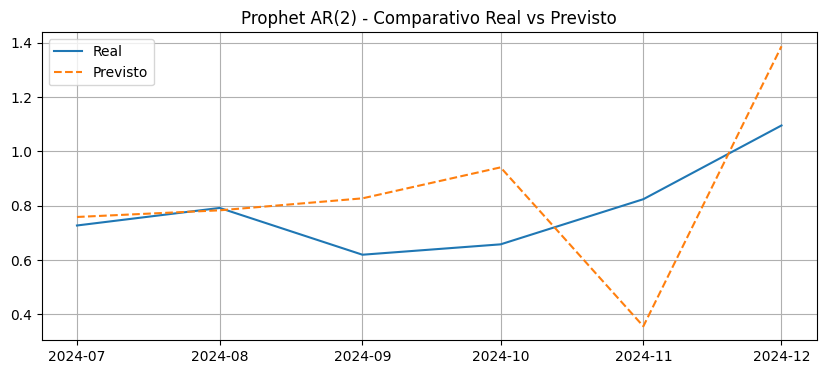

In [30]:
import matplotlib.pyplot as plt

res = resultado['forecast_df']
plt.figure(figsize=(10, 4))
plt.plot(res['ds'], res['y_true'], label='Real')
plt.plot(res['ds'], res['y_pred'], label='Previsto', linestyle='--')
plt.legend()
plt.title('Prophet AR(2) - Comparativo Real vs Previsto')
plt.grid(True)
plt.show()

In [ ]:
m = Prophet(yearly_seasonality=True,
            monthly_seasonality=False, daily_seasonality=False)
m.fit(indicadores_historicos["Lucro_Líquido"])

# Gerar previsões para 12 meses à frente
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

# Visualizar
m.plot(forecast)
m.plot_components(forecast)

TypeError: __init__() got an unexpected keyword argument 'monthly_seasonality'